In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot as gpp
from poola import core as pool
from tqdm import tqdm
import csv, requests, warnings, os
warnings.filterwarnings("ignore")

gpp.set_aesthetics(context='talk')

In [25]:
def get_annotation(filename, sheetname='Library annotation'):
    """Gets annotations for the tiling library from Supplementary Data 1
    
    :param filename: Excel file name 
    :type filename: str 
    :param sheetname: Name of sheet in Excel file
    :type sheetname: str
    :returns: Dataframe with guide annotations
    :rtype: DataFrame    
    """
    annotation = pd.read_excel(filename, 
                               sheet_name=sheetname)
    return annotation

def get_low_pdna_list(df):
    """Gets sequences of guides flagged to have low pDNA abundance
    :param df: Annotation dataframe
    :type df: DataFrame
    :returns: List of guide sequences
    :rtype: list
    """
    seq_list = df.loc[df['Low pDNA abundance'] == 'Yes','sgRNA Sequence'].to_list()
    return seq_list
    

def process_data(filename, sheetname, sgrna_colname='sgRNA Sequence'):
    """Calculates lognorms, log-fold changes for specified dataset from Supplementary Data 1
    
    :param filename: Excel file name 
    :type filename: str 
    :param sheetname: Name of sheet in Excel file
    :type sheetname: str
    :param sgrna_colname: Name of column with sgrnas
    :type sgrna_colname: str
    :returns: Dataframe with average log-fold changes of replicates
    :rtype: DataFrame
    """
    read_counts = pd.read_excel(filename, 
                                sheet_name=sheetname, 
                                header=2)
    annotation = get_annotation(filename)
    low_pdna_list = get_low_pdna_list(annotation)
    lognorms = pool.lognorm_columns(reads_df=read_counts, columns=['pDNA','RepA','RepB','RepC'])
    filtered_lognorms = lognorms[~lognorms[sgrna_colname].isin(low_pdna_list)]
    print('Filtered ' + str(lognorms.shape[0] - filtered_lognorms.shape[0]) + ' columns due to low pDNA abundance')
    lfc_df = pool.calculate_lfcs(lognorm_df=filtered_lognorms, ref_col='pDNA', target_cols=['RepA', 'RepB','RepC'])
    return lfc_df

def get_avg_lfc(lfc_df, sgrna_colname='sgRNA Sequence'):
    """Calculates average LFCs of replicates
    :param df: Dataframe with LFC of individual replicates
    :type df: DataFrame
    :param sgrna_colname: Name of column with sgrnas
    :type sgrna_colname: str    
    :returns: Dataframe with average log-fold change
    :rtype: DataFrame
    """    
    avg_replicate_lfc_df = pool.average_replicate_lfcs(lfcs=lfc_df, guide_col='sgRNA Sequence', 
                                                       condition_map={'RepA':'avg_lfc',
                                                                      'RepB':'avg_lfc', 
                                                                      'RepC':'avg_lfc'})
    avg_replicate_lfc_df = avg_replicate_lfc_df[[sgrna_colname, 'avg_lfc']]    
    return avg_replicate_lfc_df

In [5]:
import sys
print('Python version: ' + sys.version)
modules = ['pandas', 'seaborn', 'matplotlib', 'gpplot', 'numpy', 're', 'scipy', 'poola']
for module in modules:
    try:
        print(module + ' ' + sys.modules[module].__version__)
    except:
        print(module + ' has no __version__ attribute')

Python version: 3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
pandas 1.3.4
seaborn 0.11.2
matplotlib 3.4.3
gpplot 0.5.0
numpy 1.20.3
re 2.2.1
scipy 1.7.1
poola 0.0.12


This notebook helps pre-process the read counts file before performing further analysis. Here we, 
1. Filter guides that have low abundance in pDNA
2. Calculate log-fold changes relative to the pDNA per replicate
3. Look at replicate correlations
4. Calculate average LFCs per screen 
5. Merge values of all screens into a single dataframe with guide annotations

In [6]:
filename = '../Data/raw/screening/Validation_Tiling_library_readcounts_v4.xlsx'

### Step 1 & 2
Filter guides with low abundance in pDNA and calculate log-fold changes relative to the pDNA per replicate

In [39]:
#Calculate LFCs for Hsu 2013 data
hsu_lfc = process_data(filename=filename, sheetname='Hsu_2013_tracr_read_counts', sgrna_colname='sgRNA Sequence')

Filtered 37 columns due to low pDNA abundance


In [40]:
#Calculate LFCs for Chen 2013 data
chen_lfc = process_data(filename=filename, sheetname='Chen_2013_tracr_read_counts', sgrna_colname='sgRNA Sequence')

Filtered 37 columns due to low pDNA abundance


In [41]:
#Calculate LFCs for DeWeirdt 2020 data
deweirdt_lfc = process_data(filename=filename, sheetname='DeWeirdt_2020_tracr_read_counts', sgrna_colname='sgRNA Sequence')

Filtered 37 columns due to low pDNA abundance


### Step 3
Replicate correlations within screens

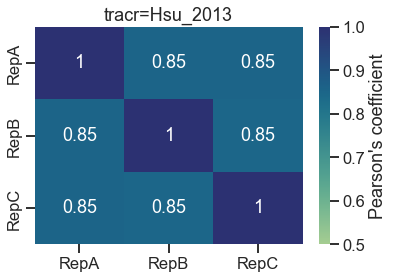

In [19]:
fig, ax = plt.subplots()
g = sns.heatmap(hsu_lfc.corr(), vmin=0.5, vmax=1.0, annot=True, cmap='crest',cbar_kws={'label': 'Pearson\'s coefficient'})
g = plt.title('tracr=Hsu_2013')

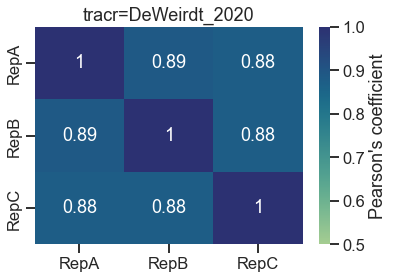

In [18]:
fig, ax = plt.subplots()
g = sns.heatmap(deweirdt_lfc.corr(), vmin=0.5, vmax=1.0, annot=True, cmap='crest',cbar_kws={'label': 'Pearson\'s coefficient'})
g = plt.title('tracr=DeWeirdt_2020')

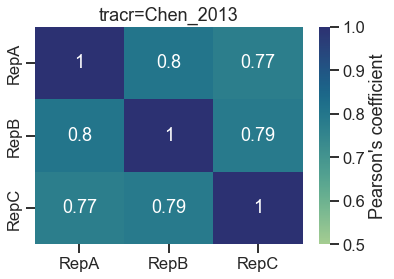

In [20]:
fig, ax = plt.subplots()
g = sns.heatmap(chen_lfc.corr(), vmin=0.5, vmax=1.0, annot=True, cmap='crest',cbar_kws={'label': 'Pearson\'s coefficient'})
g = plt.title('tracr=Chen_2013')

### Step 4
Calculate average LFCs per screen

In [43]:
hsu_lfc = get_avg_lfc(hsu_lfc)
hsu_lfc = hsu_lfc.rename(columns={'avg_lfc':'Hsu_2013_lfc'})
chen_lfc = get_avg_lfc(chen_lfc)
chen_lfc = chen_lfc.rename(columns={'avg_lfc':'Chen_2013_lfc'})
deweirdt_lfc = get_avg_lfc(deweirdt_lfc)
deweirdt_lfc = deweirdt_lfc.rename(columns={'avg_lfc':'DeWeirdt_2020_lfc'})

### Step 5
Merge values of all screens into a single dataframe with guide annotations

In [28]:
#Get library annotation
annotation = get_annotation(filename)

In [45]:
annotation.head()

,Target Gene Symbol,Target Gene ID,Target Transcript,CRISPR Mechanism,Target Domain,Reference Sequence,Strand of Target,Strand of sgRNA,Orientation,sgRNA Cut Position (1-based),...,RS3 Sequence Score (Chen2013 tracr),AA Index,Transcript Base,Missing translation information,Missing conservation information,Target Score,RS3 Sequence (Hsu2013 tracr) + Target Score,RS3 Sequence (Chen2013 tracr) + Target Score,Low pDNA abundance,Category
0,ATP5F1B,ENSG00000110955,ENST00000262030.8,CRISPRko,CDS,NC_000012.12,-,-,sense,56638325.0,...,-0.222290,530.0,ENST00000262030,0.0,0.0,-0.963343,-0.653610,-1.185633,No,Essential
1,ATP5F1B,ENSG00000110955,ENST00000262030.8,CRISPRko,CDS,NC_000012.12,-,-,sense,56640003.0,...,0.416340,422.0,ENST00000262030,0.0,0.0,0.020533,0.753194,0.436873,No,Essential
2,ATP5F1B,ENSG00000110955,ENST00000262030.8,CRISPRko,CDS,NC_000012.12,-,-,sense,56640004.0,...,0.534532,421.0,ENST00000262030,0.0,0.0,0.060108,0.607249,0.594640,No,Essential
3,ATP5F1B,ENSG00000110955,ENST00000262030.8,CRISPRko,CDS,NC_000012.12,-,-,sense,56645255.0,...,0.280994,76.0,ENST00000262030,0.0,0.0,-0.082234,0.668054,0.198760,No,Essential
4,ATP5F1B,ENSG00000110955,ENST00000262030.8,CRISPRko,CDS,NC_000012.12,-,+,antisense,56643512.0,...,0.616539,228.0,ENST00000262030,0.0,0.0,0.210275,0.953265,0.826814,No,Essential


In [47]:
#Merge annotation with LFCs
annotation_lfc = pd.merge(annotation, deweirdt_lfc, on='sgRNA Sequence')
annotation_lfc = pd.merge(annotation_lfc, hsu_lfc, on='sgRNA Sequence')
annotation_lfc = pd.merge(annotation_lfc, chen_lfc, on='sgRNA Sequence')

In [50]:
annotation_lfc.head()

,Target Gene Symbol,Target Gene ID,Target Transcript,CRISPR Mechanism,Target Domain,Reference Sequence,Strand of Target,Strand of sgRNA,Orientation,sgRNA Cut Position (1-based),...,Missing translation information,Missing conservation information,Target Score,RS3 Sequence (Hsu2013 tracr) + Target Score,RS3 Sequence (Chen2013 tracr) + Target Score,Low pDNA abundance,Category,DeWeirdt_2020_lfc,Hsu_2013_lfc,Chen_2013_lfc
0,ATP5F1B,ENSG00000110955,ENST00000262030.8,CRISPRko,CDS,NC_000012.12,-,-,sense,56638325.0,...,0.0,0.0,-0.963343,-0.653610,-1.185633,No,Essential,0.620420,0.498187,0.443741
1,ATP5F1B,ENSG00000110955,ENST00000262030.8,CRISPRko,CDS,NC_000012.12,-,-,sense,56640003.0,...,0.0,0.0,0.020533,0.753194,0.436873,No,Essential,-1.509208,-1.652624,-1.418279
2,ATP5F1B,ENSG00000110955,ENST00000262030.8,CRISPRko,CDS,NC_000012.12,-,-,sense,56640004.0,...,0.0,0.0,0.060108,0.607249,0.594640,No,Essential,-2.068677,-1.364202,-2.258415
3,ATP5F1B,ENSG00000110955,ENST00000262030.8,CRISPRko,CDS,NC_000012.12,-,-,sense,56645255.0,...,0.0,0.0,-0.082234,0.668054,0.198760,No,Essential,-1.779246,-2.188203,-1.766278
4,ATP5F1B,ENSG00000110955,ENST00000262030.8,CRISPRko,CDS,NC_000012.12,-,+,antisense,56643512.0,...,0.0,0.0,0.210275,0.953265,0.826814,No,Essential,-0.581932,-1.815441,-1.264353
